# Milwaukee Network Analysis: Traffic Assignment & Accessibility Framework

This notebook provides a comprehensive workflow for transport network modeling, ranging from data cleaning to advanced spatial accessibility metrics. The analysis is performed on the Milwaukee network using GMNS (General Modeling Network Specification) standards.

---

## 📊 Executive Summary of Operations

### 1. 🧹 GMNS Data Cleaning & Standardization
Refines the raw network data to ensure numerical stability for assignment algorithms:
* **Connector Management**: Identifies virtual links and assigns neutral BPR parameters to prevent artificial congestion.
* **Network Integrity**: Fills missing capacities and standardizes free-flow times.
* **Casting & Matching**: Aligns Zone IDs between demand and node files for perfect OD matrix mapping.

### 2. 🚗 Traffic Assignment (User Equilibrium)
Computes the network equilibrium using the **Bi-Conjugate Frank-Wolfe (BFW)** algorithm:
* **Congestion Modeling**: Calculates the Volume/Capacity (V/C) ratio for every link.
* **Flow Simulation**: Distributes vehicle demand across the network until convergence is reached.

### 📉 Congestion & Delay Metrics (BPR)
Translates traffic flows into social impact data:
* **Travel Time Analysis**: Uses the BPR function to calculate real travel times under load.
* **System Delay**: Quantifies total vehicle-hours lost and identifies the "Top 5" critical bottlenecks responsible for the majority of urban delay.

### 🗺️ Advanced Spatial Visualization
Generates high-contrast maps to visualize network performance:
* **Critical Corridors**: Highlights saturated roads using dynamic line widths based on traffic volume.
* **Social Impact Heatmaps**: Maps collective time loss across the metropolitan area using logarithmic scaling.

### ⏱️ Urban Accessibility & "City Shrinkage"
Evaluates how congestion restricts movement:
* **Isochrone Analysis**: Compares the 15-minute reachable area in Free-Flow vs. Congested scenarios.
* **Opportunity Loss**: Quantifies the percentage of the city that becomes "unreachable" due to peak-hour traffic for each zone.



In [16]:
# =============================================================================
# STANDARD LIBRARY IMPORTS
# =============================================================================
import os
import sys

# =============================================================================
# THIRD-PARTY LIBRARY IMPORTS
# =============================================================================
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from shapely import wkt

# =============================================================================
# LOCAL UTILITIES / CUSTOM MODULES
# =============================================================================
# Temporarily add source directory to path to import traffic assignment tools
sys.path.append('../src')
try:
    from utils_traffic import traffic_assignment_due_aeq
finally:
    # Always remove the path after importing to keep the environment clean
    sys.path.remove('../src')

In [17]:
# 1. Loading
# Ensure paths are correct for your environment
try:
    links = pd.read_csv('../data/link.csv')
    nodes = pd.read_csv('../data/node.csv')
    demand = pd.read_csv('../data/demand.csv')
except FileNotFoundError as e:
    print(f"Error: {e}. Check file paths.")

# 2. Surgical Identification of Connectors
# A link is a connector if it has length 0, time 0, or specific link_type (e.g., 0)
is_connector = (links['length'] <= 0) | (links['vdf_fftt'] <= 0) | (links['link_type'] == 0)

print(f"Total links: {len(links)}")
print(f"Identified connectors: {is_connector.sum()}")
print(f"Identified real roads: {(~is_connector).sum()}")

# 3. Parameter Configuration for CONNECTORS
# Connectors must be "transparent": minimum time, no congestion
links.loc[is_connector, 'vdf_fftt'] = 0.1    # 6 seconds fixed time
links.loc[is_connector, 'length'] = 0.1      # Minimum distance
links.loc[is_connector, 'capacity'] = 99999  # Virtually infinite capacity
links.loc[is_connector, 'vdf_alpha'] = 0.0   # No time increase with volume
links.loc[is_connector, 'vdf_beta'] = 1.0

# 4. Parameter Configuration for REAL ROADS
# Apply standard BPR parameters to model congestion
real_roads = ~is_connector
links.loc[real_roads, 'vdf_alpha'] = links.loc[real_roads, 'vdf_alpha'].fillna(0.15)
links.loc[real_roads, 'vdf_beta'] = links.loc[real_roads, 'vdf_beta'].fillna(4.0)

# Filling missing capacities with median (excluding 99999 from connectors)
median_cap = links.loc[real_roads & (links['capacity'] < 90000), 'capacity'].median()
links.loc[real_roads, 'capacity'] = links.loc[real_roads, 'capacity'].fillna(median_cap)

# 5. Column Renaming for Assignment (Fix KeyError: 'alpha')
# Rename now so assignment finds the correct names
links = links.rename(columns={
    'vdf_alpha': 'alpha',
    'vdf_beta': 'beta',
    'vdf_fftt': 'free_flow_time'
})

# 6. Node and Demand Alignment (Integer Casting)
# Transform zone_id to integer for perfect matching with demand
nodes['zone_id'] = pd.to_numeric(nodes['zone_id'], errors='coerce')
# Create a cleaned version of nodes for export
nodes_cleaned = nodes.copy()
# Handle NaNs before casting
nodes_cleaned['zone_id'] = nodes_cleaned['zone_id'].fillna(-1).astype(int)

# Filter demand keeping only valid zones
valid_zones = nodes_cleaned[nodes_cleaned['zone_id'] > 0]['zone_id'].unique()
demand_cleaned = demand[demand['o_zone_id'].isin(valid_zones) & demand['d_zone_id'].isin(valid_zones)].copy()

# 7. Saving
os.makedirs('../data/processed', exist_ok=True)
links.to_csv('../data/processed/link_for_assignment.csv', index=False)
nodes_cleaned.to_csv('../data/processed/node_for_assignment.csv', index=False)
demand_cleaned.to_csv('../data/processed/demand_for_assignment.csv', index=False)

print("\n--- CLEANING COMPLETE ---")
print(f"Final demand: {len(demand_cleaned)} OD records.")
print("Files in '../data/processed/' are now ready for traffic_assignment_due_aeq.")

Total links: 30747
Identified connectors: 16574
Identified real roads: 14173

--- CLEANING COMPLETE ---
Final demand: 30422 OD records.
Files in '../data/processed/' are now ready for traffic_assignment_due_aeq.


In [18]:
#verify results
print("\nVerify results:")
print(f"Total links after processing: {len(links)}")
print(f"Total nodes after processing: {len(nodes)}")
print(f"Total demand records after processing: {len(demand)}")
print(f"Sample links:\n{display(links.head())}")
print(f"Sample nodes:\n{display(nodes.head())}")
print(f"Sample demand:\n{display(demand.head())}")


Verify results:
Total links after processing: 30747
Total nodes after processing: 8521
Total demand records after processing: 30422


,link_id,from_node_id,to_node_id,dir_flag,length,vdf_length_mi,free_speed,vdf_free_speed_mph,free_flow_time,vdf_toll,link_type,alpha,beta,vdf_plf,lanes,capacity,ref_volume,obs_volume,geometry
0,25311,1,1185,1,0.1,0.0,15,9.320568,0.1,0,0,0.0,1.0,1,1,99999,0.0,0,LINESTRING (-87.88853371142858 42.996472188571...
1,25578,1,1186,1,0.1,0.0,15,9.320568,0.1,0,0,0.0,1.0,1,1,99999,0.0,0,LINESTRING (-87.88853371142858 42.996472188571...
2,25313,1,1187,1,0.1,0.0,15,9.320568,0.1,0,0,0.0,1.0,1,1,99999,0.0,0,LINESTRING (-87.88853371142858 42.996472188571...
3,25580,1,1427,1,0.1,0.0,15,9.320568,0.1,0,0,0.0,1.0,1,1,99999,0.0,0,LINESTRING (-87.88853371142858 42.996472188571...
4,25582,1,1428,1,0.1,0.0,15,9.320568,0.1,0,0,0.0,1.0,1,1,99999,0.0,0,LINESTRING (-87.88853371142858 42.996472188571...


Sample links:
None


,node_id,zone_id,x_coord,y_coord,geometry
0,1,1.0,-87.888534,42.996472,POINT (-87.88853371142858 42.99647218857143)
1,2,2.0,-87.897396,43.004612,POINT (-87.89739580689655 43.00461247356321)
2,3,3.0,-87.941012,42.986585,POINT (-87.941011752 42.986585192)
3,4,4.0,-87.905384,42.998823,POINT (-87.90538432250001 42.99882289)
4,5,5.0,-87.905679,42.992777,POINT (-87.90567903913043 42.992776747826085)


Sample nodes:
None


,o_zone_id,d_zone_id,volume
0,1,2,12
1,1,3,3
2,1,4,5
3,1,5,1
4,1,6,1


Sample demand:
None


In [19]:
# 1. LOAD CLEANED DATA
print("Loading cleaned GMNS files...")
nodes_df = pd.read_csv('../data/processed/node_for_assignment.csv')
links_df = pd.read_csv('../data/processed/link_for_assignment.csv')
demand_df = pd.read_csv('../data/processed/demand_for_assignment.csv')

# 2. PREPARE GEODATAFRAME
# Convert WKT strings to geometry objects for the assignment function
links_df['geometry'] = links_df['geometry'].apply(wkt.loads)
links_gdf = gpd.GeoDataFrame(links_df, geometry='geometry', crs="EPSG:4326")

# Rename columns to match the TP2 utility function expectations
# 'vdf_fftt' becomes 'free_flow_time' as used in our cleaning recap
links_gdf = links_gdf.rename(columns={
    'link_id': 'id',
    'from_node_id': 'a_node',
    'to_node_id': 'b_node',
    'vdf_fftt': 'free_flow_time'
})

# 3. PREPARE OD MATRIX (Mapping Zone IDs to Node IDs)
print("Mapping OD pairs to Network Nodes...")
zone_to_node = nodes_df.dropna(subset=['zone_id']).set_index('zone_id')['node_id'].astype(int).to_dict()

od_matrix = demand_df.copy()
od_matrix['origin'] = od_matrix['o_zone_id'].map(zone_to_node)
od_matrix['destination'] = od_matrix['d_zone_id'].map(zone_to_node)
od_matrix['demand'] = od_matrix['volume']

# Drop any trips that couldn't be mapped
od_matrix = od_matrix.dropna(subset=['origin', 'destination'])
od_matrix['origin'] = od_matrix['origin'].astype(int)
od_matrix['destination'] = od_matrix['destination'].astype(int)

# 4. RUN TRAFFIC ASSIGNMENT (DUE - BFW Algorithm)
print("\n" + "="*40)
print("RUNNING TRAFFIC ASSIGNMENT (User Equilibrium)")
print("="*40)

# We use 'free_flow_time' both as the base time and the cost field
results = traffic_assignment_due_aeq(
    links_gdf,
    od_matrix[['origin', 'destination', 'demand']],
    time_field='free_flow_time',
    cost_field='free_flow_time',
    algorithm='bfw',      # Bi-Conjugate Frank-Wolfe for efficiency
    iterations=100,       # Standard limit for large networks
    tolerance=1e-4        # Relative gap target
)

# 5. POST-PROCESSING RESULTS
print("\nAssignment completed successfully.")
final_net = results['network'].copy()

# Calculate the V/C Ratio (Congestion Level)
final_net['vc_ratio'] = final_net['flow'] / final_net['capacity']

# Identify critical real roads (ignoring virtual connectors with high capacity)
critical_roads = final_net[final_net['capacity'] < 90000].sort_values(by='vc_ratio', ascending=False)

print("\n--- TOP 5 CONGESTED SEGMENTS ---")
print(critical_roads[['id', 'a_node', 'b_node', 'flow', 'capacity', 'vc_ratio']].head(5))

# 6. SAVE OUTPUT
#creating output directory if not exists
os.makedirs('../data/simulation', exist_ok=True)
output_path = '../data/simulation/milwaukee_assignment_results.csv'
final_net.to_csv(output_path, index=False)
print(f"\nFull results saved to: {output_path}")

Loading cleaned GMNS files...
Mapping OD pairs to Network Nodes...

RUNNING TRAFFIC ASSIGNMENT (User Equilibrium)


No pre-existing parameter file exists for this project. Will use default
No pre-existing parameter file exists for this project. Will use default
No pre-existing parameter file exists for this project. Will use default
No pre-existing parameter file exists for this project. Will use default
No pre-existing parameter file exists for this project. Will use default
No pre-existing parameter file exists for this project. Will use default
No pre-existing parameter file exists for this project. Will use default
No pre-existing parameter file exists for this project. Will use default


car                                               :   0%|          | 0/234 [00:00<?, ?it/s]

Equilibrium Assignment                            :   0%|          | 0/100 [00:00<?, ?it/s]

Reset line search
Desired RGap of 0.0001 was NOT reached


Assignment completed successfully in 12.30 seconds.
Assignment Results:
Algorithm: bfw 
Iterations: 100
Tolerance: 0.0001 
Total Travel Time: 683652.70 
RGAP: 0.000280


Assignment completed successfully.

--- TOP 5 CONGESTED SEGMENTS ---
          id  a_node  b_node         flow  capacity  vc_ratio
13284  21153    1902    1900  7827.111167      1400  5.590794
27841   8577    7421    2959  6533.097097      1400  4.666498
21269  21494    4792    4793  8802.755249      2000  4.401378
13278  21152    1900    1902  5867.694628      1400  4.191210
21924   9882    5063    5064  9152.517608      2200  4.160235

Full results saved to: ../data/simulation/milwaukee_assignment_results.csv


Original V/C range: 0.00 - 5.59
Values rescaled to [0, 1] interval for visualization purposes.


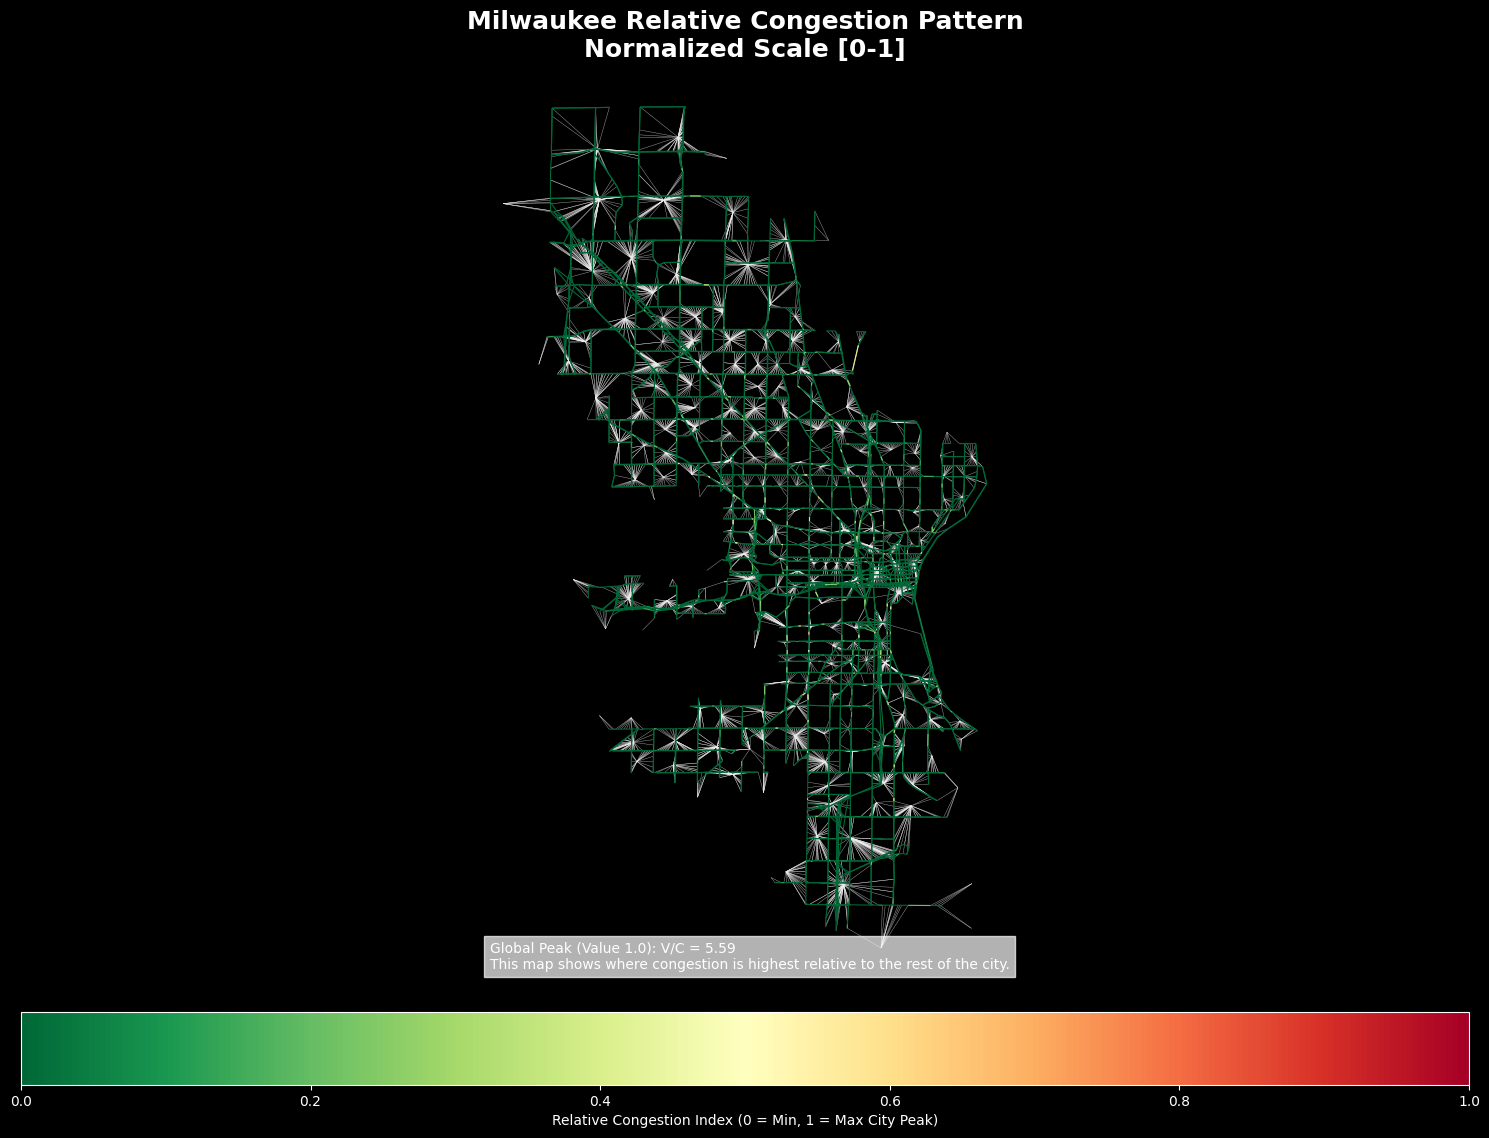

In [20]:
# =============================================================================
# SECTION 1: DATA LOADING
# =============================================================================
# Load simulation results and convert to geospatial format
results_path = '../data/simulation/milwaukee_assignment_results.csv'
df = pd.read_csv(results_path)

# Convert geometry strings to actual geometric objects
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# =============================================================================
# SECTION 2: FILTERING
# =============================================================================
# Exclude high-capacity virtual connectors for statistical congestion analysis
roads = gdf[gdf['capacity'] < 90000].copy()

# =============================================================================
# SECTION 3: NORMALIZATION (Range 0 to 1)
# =============================================================================
# Scale the V/C ratio to a standardized range for visualization
# Formula: (x - min) / (max - min)
vc_min = roads['vc_ratio'].min()
vc_max = roads['vc_ratio'].max()
roads['vc_norm'] = (roads['vc_ratio'] - vc_min) / (vc_max - vc_min)

print(f"Original V/C range: {vc_min:.2f} - {vc_max:.2f}")
print("Values rescaled to [0, 1] interval for visualization purposes.")

# =============================================================================
# SECTION 4: PLOT GENERATION
# =============================================================================
fig, ax = plt.subplots(figsize=(15, 12))

# Background: Render virtual connectors in very light grey
gdf[gdf['capacity'] >= 90000].plot(ax=ax, color='#f0f0f0', linewidth=0.3, alpha=0.4)

# Plot real roads using a normalized color map (Green to Red)
# This highlights relative congestion hotspots across the network
plot = roads.plot(
    ax=ax, 
    column='vc_norm', 
    cmap='RdYlGn_r', 
    linewidth=0.8,
    legend=True,
    legend_kwds={'label': "Relative Congestion Index (0 = Min, 1 = Max City Peak)", 
                  'orientation': "horizontal", 'pad': 0.02}
)

# =============================================================================
# SECTION 5: FINALIZATION
# =============================================================================
ax.set_title('Milwaukee Relative Congestion Pattern\nNormalized Scale [0-1]', fontsize=18, fontweight='bold')
ax.set_axis_off()

# Add annotation for peak values
ax.text(0.02, 0.02, 
        f"Global Peak (Value 1.0): V/C = {vc_max:.2f}\n"
        "This map shows where congestion is highest relative to the rest of the city.", 
        transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
        bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig('../results/milwaukee_relative_congestion.png', dpi=300)
plt.show()

Visualization optimized: V/C > 1.0 will appear in deep red.


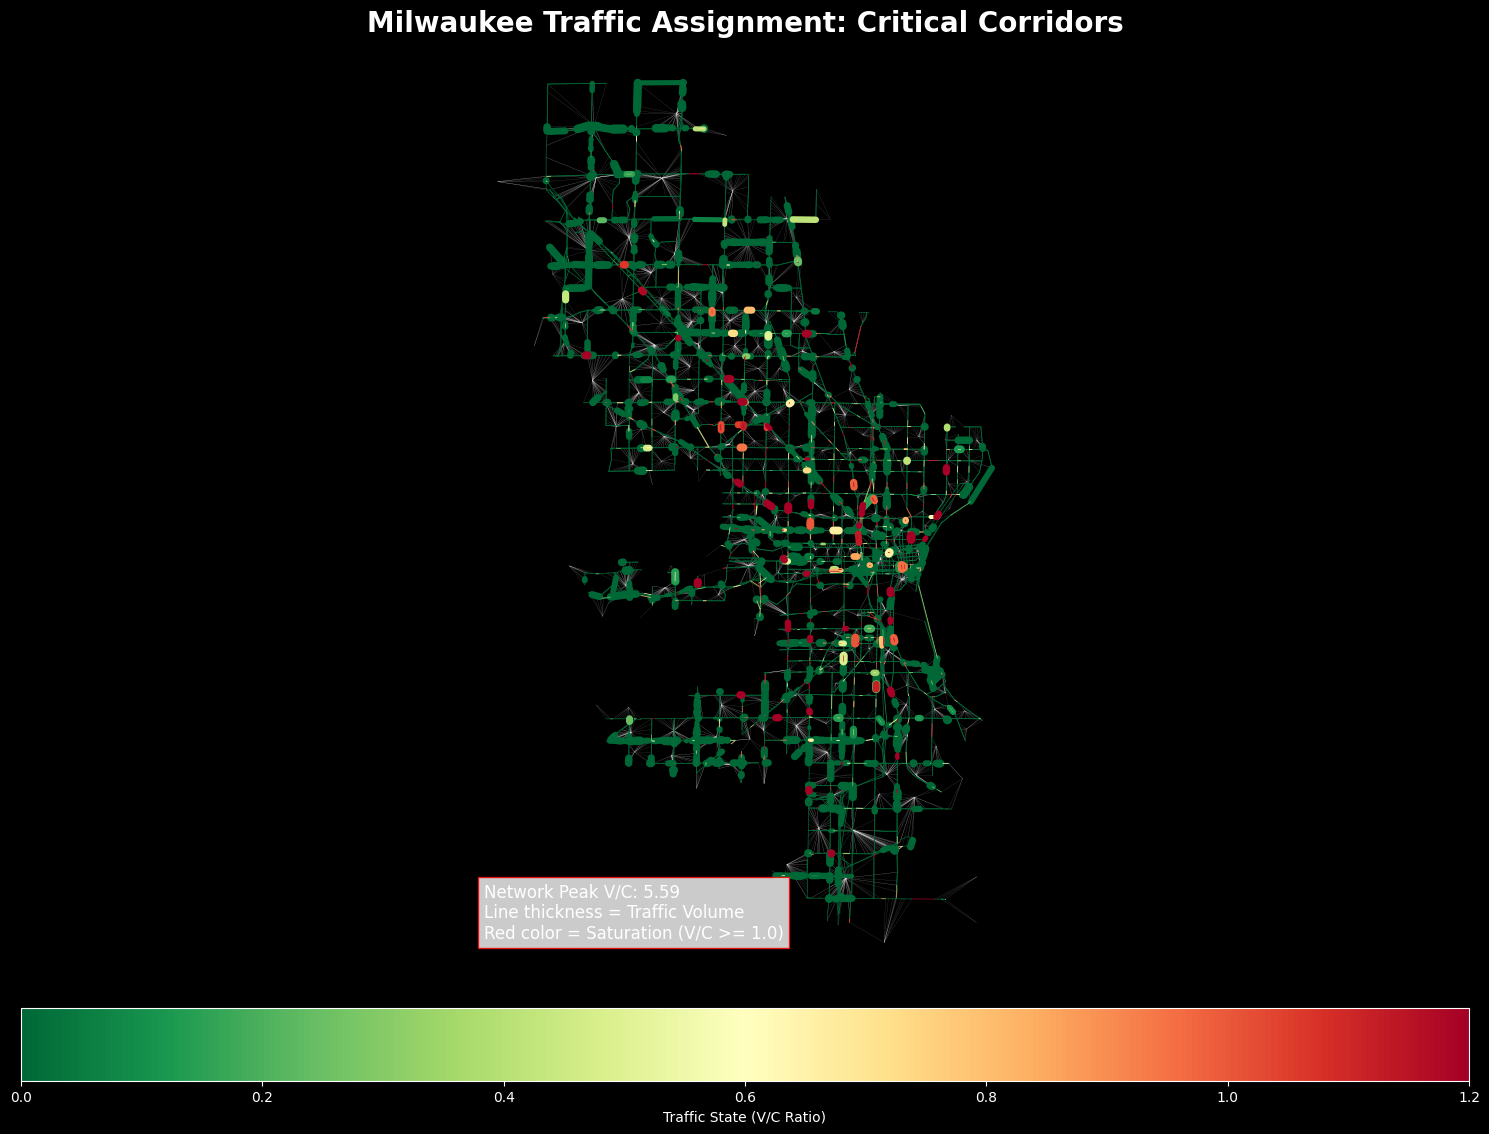

In [21]:
# 1. DATA LOADING
# Path to the simulation results
results_path = '../data/simulation/milwaukee_assignment_results.csv'
df = pd.read_csv(results_path)

# Convert geometry strings to spatial objects and create a GeoDataFrame
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# 2. FILTERING
# Separate real road segments from virtual connectors
roads = gdf[gdf['capacity'] < 90000].copy()

# 3. VISUALIZATION PREPARATION
# Cap the V/C ratio at 1.2 to highlight saturated corridors in deep red
roads['vc_visual'] = roads['vc_ratio'].clip(upper=1.2)

# Define dynamic line width based on traffic volume for better visual hierarchy
roads['l_width'] = 0.5 + (np.log1p(roads['flow']) / 1.5)

print(f"Visualization optimized: V/C > 1.0 will appear in deep red.")

# 4. PLOT GENERATION
fig, ax = plt.subplots(figsize=(15, 12))

# Plot background connectors with minimal visual weight
gdf[gdf['capacity'] >= 90000].plot(ax=ax, color='#eeeeee', linewidth=0.1, alpha=0.3)

# Render roads with color mapping and dynamic thickness
# Sorted by vc_ratio to ensure critical links are plotted on top
plot = roads.sort_values('vc_ratio').plot(
    ax=ax, 
    column='vc_visual', 
    cmap='RdYlGn_r', 
    linewidth=roads['l_width'], 
    capstyle='round',           
    joinstyle='round',
    vmin=0, 
    vmax=1.2, 
    legend=True,
    legend_kwds={'label': "Traffic State (V/C Ratio)", 'orientation': "horizontal", 'pad': 0.02}
)

# 5. FINALIZATION
ax.set_title('Milwaukee Traffic Assignment: Critical Corridors', fontsize=20, fontweight='bold')
ax.set_facecolor('white')
ax.set_axis_off()

# Add summary annotations
max_vc = roads['vc_ratio'].max()
ax.text(0.02, 0.05, 
        f"Network Peak V/C: {max_vc:.2f}\nLine thickness = Traffic Volume\nRed color = Saturation (V/C >= 1.0)", 
        transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))

plt.tight_layout()
plt.show()

In [22]:

# =============================================================================
# SECTION 1: ASSIGNMENT RESULTS LOADING
# =============================================================================
# Load the results generated by the traffic assignment process
results_path = '../data/simulation/milwaukee_assignment_results.csv'
df = pd.read_csv(results_path)

# =============================================================================
# SECTION 2: CONGESTED TIME CALCULATION (BPR)
# =============================================================================
# Applying the BPR (Bureau of Public Roads) function to calculate real travel times
# Standard parameters for urban networks: alpha = 0.15, beta = 4.0
alpha = 0.15
beta = 4.0

# Calculate final congested time per link
df['congested_time'] = df['free_flow_time'] * (1 + alpha * (df['vc_ratio']**beta))

# Calculate individual vehicle delay (in minutes)
df['delay_per_veh'] = df['congested_time'] - df['free_flow_time']

# Calculate total system delay (aggregate minutes lost by all users on the link)
df['total_system_delay'] = df['delay_per_veh'] * df['flow']

# =============================================================================
# SECTION 3: SYSTEM PERFORMANCE & ACCESSIBILITY METRICS
# =============================================================================
# Convert aggregate minutes into total vehicle-hours lost
total_hours_lost = df['total_system_delay'].sum() / 60
print("--- CONGESTION IMPACT ANALYSIS ---")
print(f"Total system delay: {total_hours_lost:.2f} vehicle-hours")

# Identify critical segments responsible for 50% of the total city delay
df_sorted = df.sort_values('total_system_delay', ascending=False)
df_sorted['cumulative_delay_pct'] = (
    df_sorted['total_system_delay'].cumsum() / df_sorted['total_system_delay'].sum()
)
bottlenecks = df_sorted[df_sorted['cumulative_delay_pct'] <= 0.5]

print(f"Number of critical links causing 50% of the delay: {len(bottlenecks)}")
print("\nTop 5 Segments by Social Impact (Total Delay):")
print(bottlenecks[['id', 'flow', 'vc_ratio', 'total_system_delay']].head(5))

# =============================================================================
# SECTION 4: DATA EXPORT
# =============================================================================
# Save the enriched dataset for further spatial analysis (accessibility impact)
output_path = '../data/simulation/milwaukee_accessibility_impact.csv'
df.to_csv(output_path, index=False)
print(f"\nAccessibility impact data saved to: {output_path}")

--- CONGESTION IMPACT ANALYSIS ---
Total system delay: 10781.38 vehicle-hours
Number of critical links causing 50% of the delay: 10

Top 5 Segments by Social Impact (Total Delay):
          id         flow  vc_ratio  total_system_delay
16096  28950  4566.000000  3.261429        98946.737868
21269  21494  8802.755249  4.401378        52796.599372
21248  21419  8305.389524  4.152695        30623.197799
15006   9615  7949.629756  3.974815        24268.726979
13284  21153  7827.111167  5.590794        22445.695473

Accessibility impact data saved to: ../data/simulation/milwaukee_accessibility_impact.csv


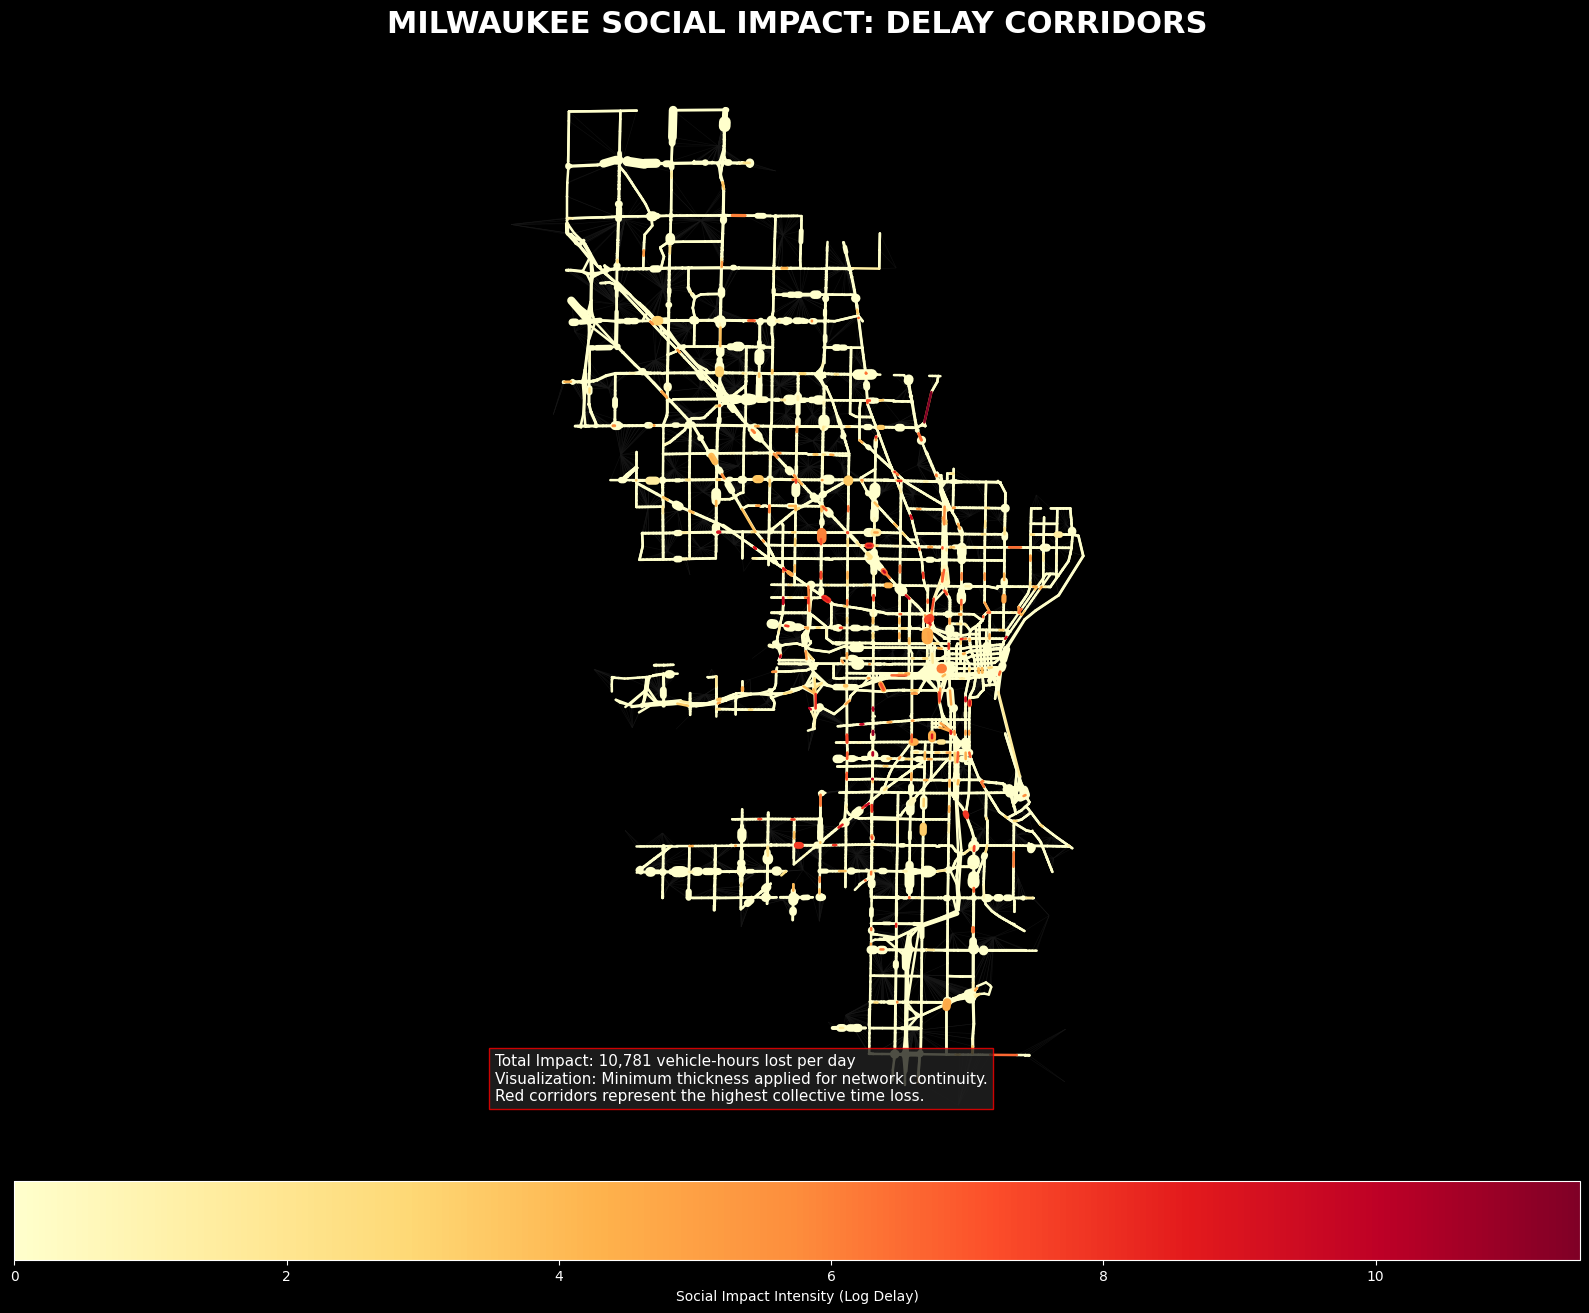

In [23]:
# =============================================================================
# SECTION 1: DATA LOADING
# =============================================================================
# Load the accessibility impact data and convert to a GeoDataFrame
df = pd.read_csv('../data/simulation/milwaukee_accessibility_impact.csv')
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# =============================================================================
# SECTION 2: NETWORK FILTERING
# =============================================================================
# Focus analysis on physical road segments, excluding virtual connectors
roads = gdf[gdf['capacity'] < 90000].copy()

# =============================================================================
# SECTION 3: NETWORK CONTINUITY LOGIC
# =============================================================================
# Set a base thickness for visual continuity and calculate 
# variable width based on total system delay (logarithmic scale)
roads['delay_log'] = np.log1p(roads['total_system_delay'])

# Formula: Thickness = Base (1.8) + Scaled Social Delay component
roads['l_width'] = 1.8 + (roads['delay_log'] / 1.5)

# =============================================================================
# SECTION 4: HIGH-CONTRAST SPATIAL VISUALIZATION
# =============================================================================
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(16, 14))

# Plot background: virtual connectors and low-delay links
gdf.plot(ax=ax, color='#1a1a1a', linewidth=0.5, alpha=0.3)

# Plot delay intensity: real road segments only
# Sorting ensures higher delay links are rendered on top for better visibility
plot = roads.sort_values('total_system_delay').plot(
    ax=ax, 
    column='delay_log', 
    cmap='YlOrRd', 
    linewidth=roads['l_width'], 
    capstyle='round',           # Smooth segment ends for network connectivity
    joinstyle='round',          # Smooth junctions
    legend=True,
    legend_kwds={'label': "Social Impact Intensity (Log Delay)", 
                  'orientation': "horizontal", 'pad': 0.02}
)

# =============================================================================
# SECTION 5: FINALIZATION & ANNOTATION
# =============================================================================
ax.set_title('MILWAUKEE SOCIAL IMPACT: DELAY CORRIDORS', 
             fontsize=22, fontweight='bold', color='white', pad=20)
ax.set_axis_off()

# Compute summary statistics for display
total_hours = df['total_system_delay'].sum() / 60
ax.text(0.02, 0.05, 
        f"Total Impact: {total_hours:,.0f} vehicle-hours lost per day\n"
        "Visualization: Minimum thickness applied for network continuity.\n"
        "Red corridors represent the highest collective time loss.", 
        transform=ax.transAxes, color='white', fontsize=11, 
        bbox=dict(facecolor='#222222', alpha=0.8, edgecolor='red'))

plt.tight_layout()
plt.show()

Running global analysis... calculating spatial contraction per zone.


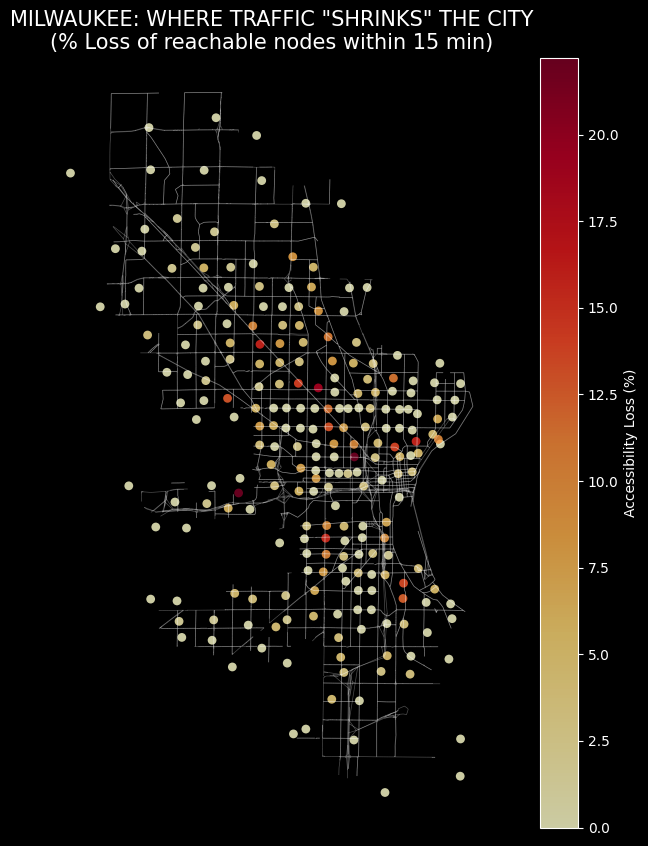

C:\Users\alera\AppData\Local\Temp\ipykernel_19272\83956707.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10, x='zone_id', y='loss_pct', palette='Reds_r')


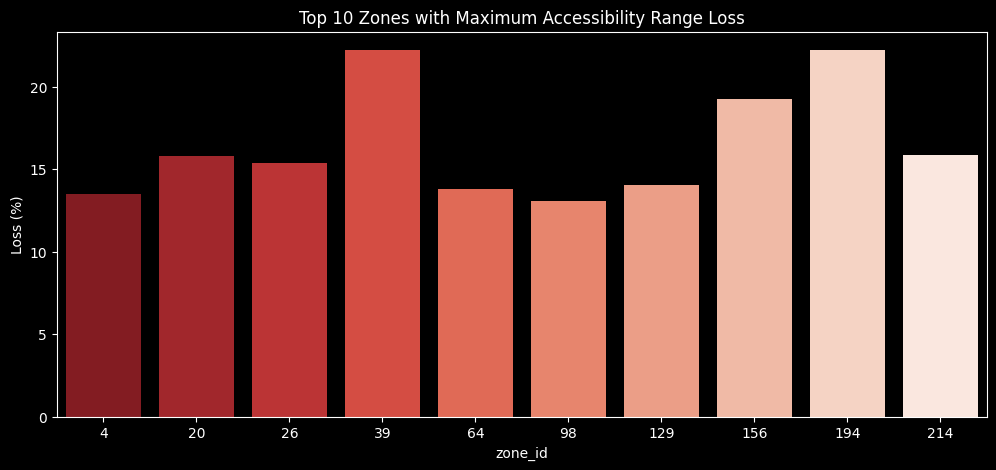

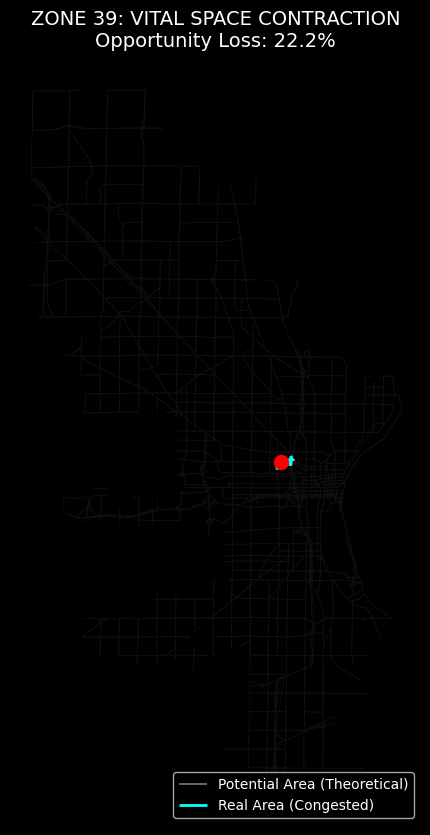

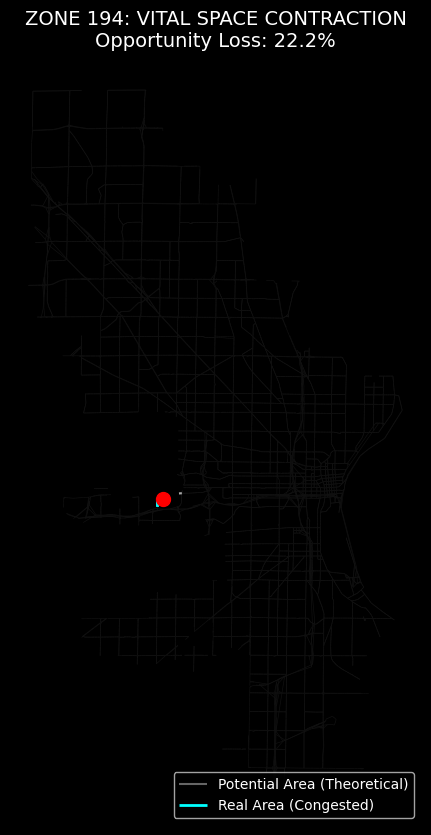

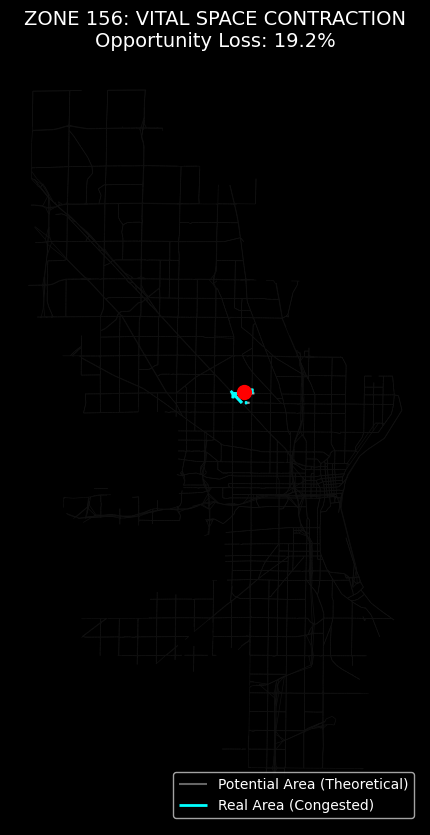

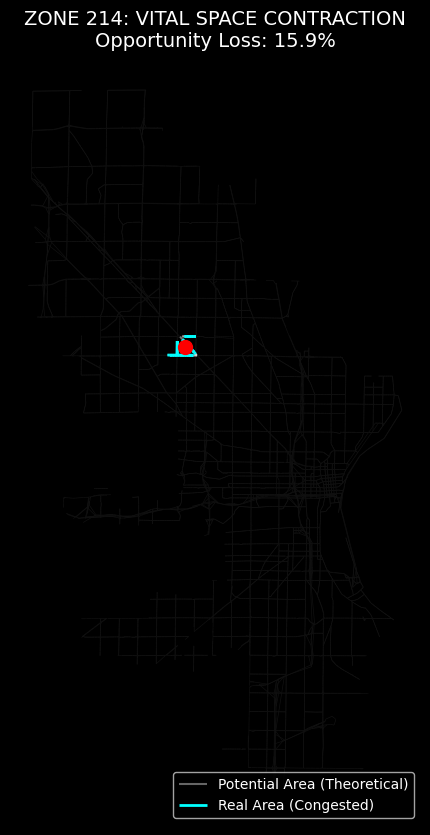

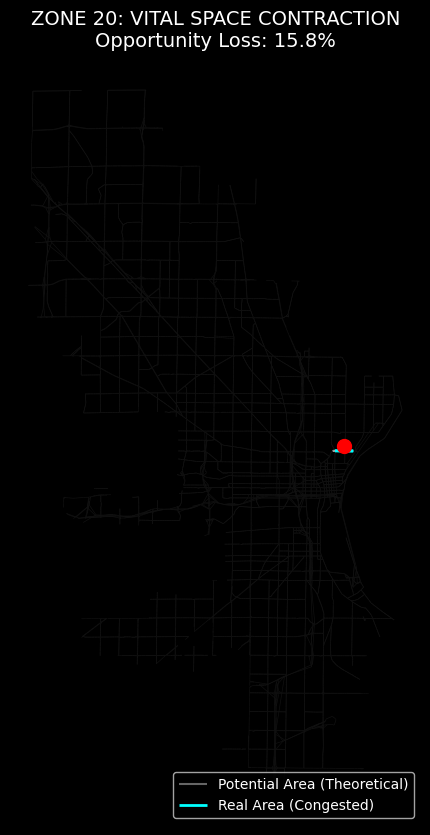

In [24]:
# =============================================================================
# SECTION 1: DATA LOADING & PREPARATION
# =============================================================================
# Load impact data and node information
df = pd.read_csv('../data/simulation/milwaukee_accessibility_impact.csv')
nodes = pd.read_csv('../data/processed/node_for_assignment.csv')

# Convert to GeoDataFrame
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# --- COLUMN ALIGNMENT & TIME UNIT NORMALIZATION ---
col_from = 'from_node_id' if 'from_node_id' in df.columns else 'a_node'
col_to = 'to_node_id' if 'to_node_id' in df.columns else 'b_node'

# Ensure travel times are in minutes for consistent routing
avg_time = df['free_flow_time'].mean()
if avg_time < 0.5:     # Detected as Hours
    df['t_ff'] = df['free_flow_time'] * 60
    df['t_cong'] = df['congested_time'] * 60
elif avg_time > 20:   # Detected as Seconds
    df['t_ff'] = df['free_flow_time'] / 60
    df['t_cong'] = df['congested_time'] / 60
else:                 # Already in Minutes
    df['t_ff'] = df['free_flow_time']
    df['t_cong'] = df['congested_time']

# =============================================================================
# SECTION 2: GRAPH CONSTRUCTION
# =============================================================================
# Build Directed Graphs for both Free-Flow and Congested scenarios
G_ff = nx.DiGraph()
G_cong = nx.DiGraph()

for _, row in df.iterrows():
    G_ff.add_edge(row[col_from], row[col_to], weight=row['t_ff'])
    G_cong.add_edge(row[col_from], row[col_to], weight=row['t_cong'])

# =============================================================================
# SECTION 3: GLOBAL ACCESSIBILITY ANALYSIS (15-MINUTE THRESHOLD)
# =============================================================================
# Calculate spatial contraction for every zone in the network
centroid_nodes = nodes[nodes['zone_id'] > 0]['node_id'].unique()
results = []

print("Running global analysis... calculating spatial contraction per zone.")
for node in centroid_nodes:
    if node in G_ff and node in G_cong:
        # Number of reachable nodes within 15 minutes
        reach_ff = len(nx.single_source_dijkstra_path_length(G_ff, node, cutoff=15))
        reach_cong = len(nx.single_source_dijkstra_path_length(G_cong, node, cutoff=15))
        
        # Calculate percentage loss of reach
        loss = ((reach_ff - reach_cong) / reach_ff * 100) if reach_ff > 0 else 0
        results.append({'node_id': node, 'loss_pct': loss, 'reach_ff': reach_ff})

# Merge results with spatial coordinates
acc_df = pd.DataFrame(results).merge(nodes[['node_id', 'zone_id', 'x_coord', 'y_coord']], on='node_id')

# =============================================================================
# SECTION 4: VISUALIZATION 1 - ACCESSIBILITY LOSS MAP
# =============================================================================
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 10))
gdf[gdf['capacity'] < 90000].plot(ax=ax, color="#ffffff", linewidth=0.5, alpha=0.3)

scatter = ax.scatter(acc_df['x_coord'], acc_df['y_coord'], 
                     c=acc_df['loss_pct'], cmap='YlOrRd', s=40, alpha=0.8, edgecolors='none')

plt.colorbar(scatter, label='Accessibility Loss (%)')
ax.set_title('MILWAUKEE: WHERE TRAFFIC "SHRINKS" THE CITY\n(% Loss of reachable nodes within 15 min)', fontsize=15)
ax.set_axis_off()
plt.show()

# =============================================================================
# SECTION 5: VISUALIZATION 2 - TOP 10 CRITICAL ZONES
# =============================================================================
plt.figure(figsize=(12, 5))
top_10 = acc_df.sort_values('loss_pct', ascending=False).head(10)
sns.barplot(data=top_10, x='zone_id', y='loss_pct', palette='Reds_r')
plt.title('Top 10 Zones with Maximum Accessibility Range Loss')
plt.ylabel('Loss (%)')
plt.show()

# =============================================================================
# SECTION 6: VISUALIZATION 3 - TOP 5 ISOCHRONE COMPARISONS
# =============================================================================
# Detailed view of the reach contraction for the worst affected zones
worst_5 = top_10['node_id'].head(5).tolist()
is_real_road = gdf['capacity'] < 90000



for node_id in worst_5:
    z_id = acc_df[acc_df['node_id'] == node_id]['zone_id'].values[0]
    loss_val = acc_df[acc_df['node_id'] == node_id]['loss_pct'].values[0]
    
    # Calculate specific sets of reachable nodes
    nodes_ff = nx.single_source_dijkstra_path_length(G_ff, node_id, cutoff=15)
    nodes_cong = nx.single_source_dijkstra_path_length(G_cong, node_id, cutoff=15)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf[is_real_road].plot(ax=ax, color='#111111', linewidth=0.5)
    
    # Potential Area (Free Flow)
    iso_ff = gdf[is_real_road & gdf[col_from].isin(nodes_ff.keys()) & gdf[col_to].isin(nodes_ff.keys())]
    iso_ff.plot(ax=ax, color="#FFFFFF", alpha=0.4, label='Potential Area (Theoretical)')
    
    # Real Area (Congested)
    iso_cong = gdf[is_real_road & gdf[col_from].isin(nodes_cong.keys()) & gdf[col_to].isin(nodes_cong.keys())]
    iso_cong.plot(ax=ax, color='#00FFFF', linewidth=2, label='Real Area (Congested)', zorder=3)
    
    # Origin Node
    start_pt = acc_df[acc_df['node_id'] == node_id]
    ax.scatter(start_pt['x_coord'], start_pt['y_coord'], color='red', s=100, zorder=5)
    
    plt.title(f"ZONE {int(z_id)}: VITAL SPACE CONTRACTION\nOpportunity Loss: {loss_val:.1f}%", fontsize=14)
    plt.legend(loc='lower right')
    plt.axis('off')
    plt.show()